# Data Sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.ExcelFile('PATIENT2.xlsx')
data0 = pd.ExcelFile('CONTROL2.xlsx')

AAo = pd.read_excel(data,"AAo")
AAo0 = pd.read_excel(data0,"AAo")
AArch = pd.read_excel(data,"AArch")
AArch0 = pd.read_excel(data0,"AArch")

AAo = AAo.drop(["Diameter"], axis=1)
AAo = AAo.drop(AAo[AAo["Classification"]==3].index)
AAo0 = AAo0.drop(["Diameter"], axis=1)
AAo0 = AAo0.drop(AAo0[AAo0["Classification"]==3].index)

AArch = AArch.drop(["Diameter"], axis=1)
AArch = AArch.drop(AArch[AArch["Classification"]==3].index)
AArch0 = AArch0.drop(["Diameter"], axis=1)
AArch0 = AArch0.drop(AArch0[AArch0["Classification"]==3].index)

AAo_and_AArch = pd.concat([AAo, AArch], axis = 0)
Control_AAo_and_AArch = pd.concat([AAo0, AArch0], axis = 0)
Base = AAo_and_AArch

#Pacientes tipo 0
Control_AAo_and_AArch = pd.concat([AAo0, AArch0], axis = 0)

#Pacientes tipo 1
PAT1 = AAo_and_AArch.drop(AAo_and_AArch[AAo_and_AArch["Classification"]==2].index)

#Pacientes tipo 2
PAT2 = Base.drop(Base[Base["Classification"]==1].index)

PAT0 = Control_AAo_and_AArch.drop(["Classification"], axis=1)
PAT1 = PAT1.drop(["Classification"], axis=1)
PAT2 = PAT2.drop(["Classification"], axis=1)

PAT0and1 = pd.concat([PAT0, PAT1], axis = 0)
PAT0and2 = pd.concat([PAT0, PAT2], axis = 0)
PAT1and2 = pd.concat([PAT1, PAT2], axis = 0)
PAT012 = pd.concat([PAT0, PAT1, PAT2], axis = 0)

# Random Forest Regression

In [3]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [4]:
PAT0and1.head()

,Eccentricity,Velocity,Forward Velocity,Backward Velocity,Velocity Angle,Regurgitation Fraction,WSS,WSS A,WSS C,OSI,Vorticity,Axial Vorticity,Axial Circulation,Helicity Density,Viscous Dissipation,Energy Loss,Kinetic Energy,Age
0,24.2855,0.450737,0.435594,0.000374,14.34480,4.29674,0.551875,0.523518,0.112739,0.131044,72.0498,6.51484,42.2948,5.80341,7.10248,0.453022,2.369770,15.33
1,16.4605,0.288124,0.270906,0.000170,17.28590,15.32920,0.347154,0.312661,0.108406,0.208297,32.9119,1.12278,12.4323,3.21654,1.73843,0.112291,0.876954,48.58
2,17.9077,0.624304,0.607896,0.000155,11.70530,5.38498,0.851600,0.825076,0.142330,0.146227,75.4844,5.93202,47.1119,12.36190,8.52688,0.540140,4.114740,20.83
3,14.4815,0.556402,0.540973,0.000000,9.67889,4.92253,1.049700,1.022020,0.161974,0.090487,67.2755,3.09048,19.2470,9.99619,4.40890,0.201055,2.534210,29.08
4,16.8752,0.504075,0.488241,0.000011,11.66770,5.80656,0.852800,0.820310,0.175408,0.123225,48.0529,6.82434,39.7283,8.33330,3.32362,0.157492,2.020290,48.00


La clase RandomForestRegressor del módulo sklearn.ensemble permite entrenar modelos random forest para problemas de regresión. Los parámetros e hiperparámetros empleados por defecto son:

n_estimators=100

criterion='mse'

max_depth=None

min_samples_split=2

min_samples_leaf=1

min_weight_fraction_leaf=0.0

max_features='auto'

max_leaf_nodes=None

min_impurity_decrease=0.0

min_impurity_split=None

bootstrap=True

oob_score=False

n_jobs=None

random_state=None

verbose=0

warm_start=False

ccp_alpha=0.0

max_samples=None

In [8]:
#def RandomForestReg(datos):
datos = PAT0and1
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "Age"),
                                        datos['Age'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
        )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

#RandomForestReg(PAT0and1)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', n_estimators=10, n_jobs=-1,
                      random_state=123)

In [9]:
# Error de test del modelo inicial
# ==============================================================================

predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 15.59135406680137


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion '

Valor óptimo de n_estimators: 96


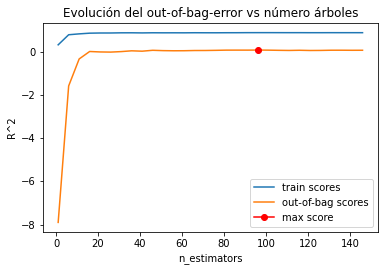

In [10]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Valor óptimo de n_estimators: 46


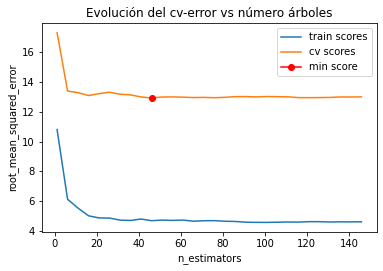

In [23]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Ambas metricas indican que, a partir de entre 46 y 96 arboles, el error de validacion del modelo se estabiliza.

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Valor óptimo de max_features: 14


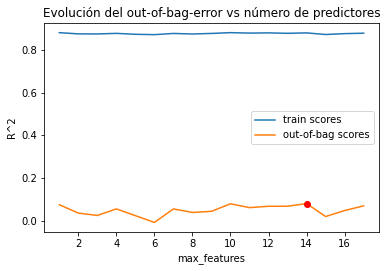

In [12]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Valor óptimo de max_features: 2


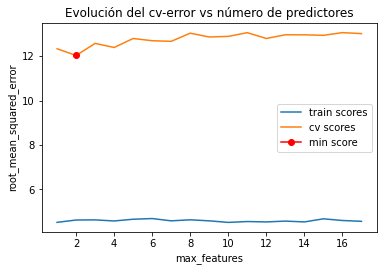

In [13]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

De acuerdo a ambas metricas, el valor optimo de max_features se encuentra entre 2 y 14

In [14]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [2, 8, 14],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 14, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 14, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 14, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 14, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
3,0.095127,3.0,2.0,150.0
5,0.064245,3.0,14.0,150.0
4,0.059287,3.0,8.0,150.0
0,0.051727,NaN,2.0,150.0


In [15]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [2, 8, 14],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_r2': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train, y_train, RandomForestRegressor(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 14, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 14, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 14, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 8, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 14, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
3,0.095127,3.0,2.0,150.0
5,0.064245,3.0,14.0,150.0
4,0.059287,3.0,8.0,150.0
0,0.051727,NaN,2.0,150.0


In [16]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.09512711725563028 : 0.09512711725563028 R2


In [17]:
# GridSearch Validacion Cruzada
#Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [2, 8, 14],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
3,3,2,150,-12.255265,1.947846,-9.035357,0.354251
4,3,8,150,-12.294430,1.876320,-8.275336,0.312689
5,3,14,150,-12.324268,1.756634,-7.987231,0.295625
6,10,2,150,-12.356599,1.826702,-4.683428,0.184904


In [18]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 3, 'max_features': 2, 'n_estimators': 150} : -12.255264659559742 neg_root_mean_squared_error


In [19]:
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 12.986223156438571


El error bajo de 15.59 a 12.98

In [20]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "Age").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,Velocity Angle,0.161785
0,Eccentricity,0.133115
5,Regurgitation Fraction,0.111245
2,Forward Velocity,0.079993
9,OSI,0.053123
11,Axial Vorticity,0.051529
8,WSS C,0.044123
12,Axial Circulation,0.044062
7,WSS A,0.043711
10,Vorticity,0.043678


In [21]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
4,0.541705,0.126657,Velocity Angle
11,0.409742,0.073743,Axial Vorticity
5,0.401570,0.139431,Regurgitation Fraction
0,0.380574,0.093155,Eccentricity
2,0.313762,0.041935,Forward Velocity
7,0.305372,0.056470,WSS A
9,0.255875,0.052000,OSI
10,0.229665,0.030348,Vorticity
12,0.214028,0.013597,Axial Circulation
3,0.208236,0.064057,Backward Velocity


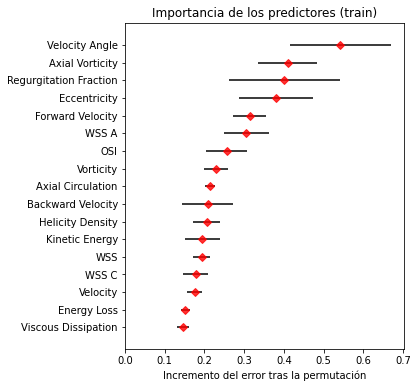

In [22]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

Ambas estrategias muestran que los siguientes parametros son los predictores más influyentes, acorde a los datos de entrenamiento. 

*   Velocity Angle
*   Axial Vorticity
*   Regurgitation Fraction

